## Tutorial 3a - Convolutional Neural Networks 

### Convolutional Neural Networks

In the last lecture we discussed how convolutional neural networks (CNNs) can take advantage of spatial features to improve classification on images. In essence this is achieved by having the network learn kernel parameters to identify lines, edges, corners, colours and other patterns all the way to higher level complexities that can represent objects in the image and strengthen the decision making process.

As a result of the spatial features CNNs can handle translational variations in images or simply put, we are able to find objects that are not perfectly centered in the image.


## From ANN to CNN
In the example below you'll see that to go from an ANN to a CNN we only need to make a few changes to our architecture. The rest of the code remains the same.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

# obtain data
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:4096]
mnist_val   = mnist_data[4096:5120]

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:06<00:00, 1489238.65it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 769579.71it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 757485.45it/s] 


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3933621.47it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### ANN and CNN Architectures
Provided is sample code showing the differences between a basic ANN and CNN architectures. Notice that the CNN architecture also contains fully connected layers.

In [2]:
class ANN_MNISTClassifier(nn.Module):
    def __init__(self):
        super(ANN_MNISTClassifier, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 10)  

    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = F.relu(self.fc1(flattened))
        activation2 = F.relu(self.fc2(activation1))
        output = self.fc3(activation2)
        return output
    
    print('Artificial Neural Network Architecture (aka MLP) Done')

#Convolutional Neural Network Architecture
class CNN_MNISTClassifier(nn.Module):
    def __init__(self):
        super(CNN_MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 5) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(160, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 160)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')

Artificial Neural Network Architecture (aka MLP) Done
Convolutional Neural Network Architecture Done


The general formula is this if you are interested: $[(W−K+2P)/S]+1$.

* $W$ is the input size 
* $K$ is the Kernel size 
* $P$ is the padding 
* $S$ is the stride

==============================================================

* $28\times 28$ (1ch) => conv1 => $24\times24$ (5ch) --- (28-5+1)
* $24\times24$ (5ch) => pool => $12\times12$ (5ch)
* $12\times12$ (5ch) => conv2 => $8\times8$ (10ch)
* $8\times8$ (10ch) => pool => $4\times4$ (10ch)
* $4\times4$ (10ch)  => Flat => $4\times4\times10 = 160$


![Conv](https://miro.medium.com/max/1050/1*K_OsaLGJ7I8cGlPvvWYJdg.png)

https://cs231n.github.io/convolutional-networks/

In [3]:
def get_accuracy(model, train=False):
    if train:
        data = mnist_train
    else:
        data = mnist_val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [4]:
def train(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Comparing ANNs and CNNs

ANN
ANN_MNISTClassifier(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
)


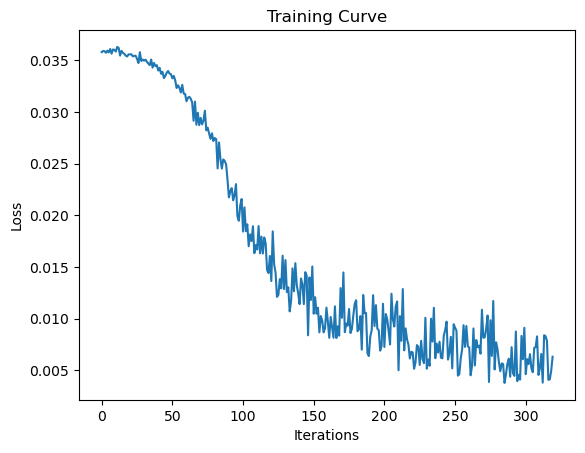

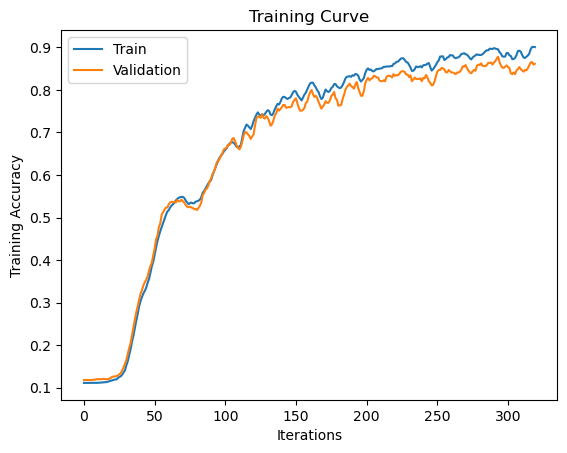

Final Training Accuracy: 0.900390625
Final Validation Accuracy: 0.861328125
CNN
CNN_MNISTClassifier(
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=160, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


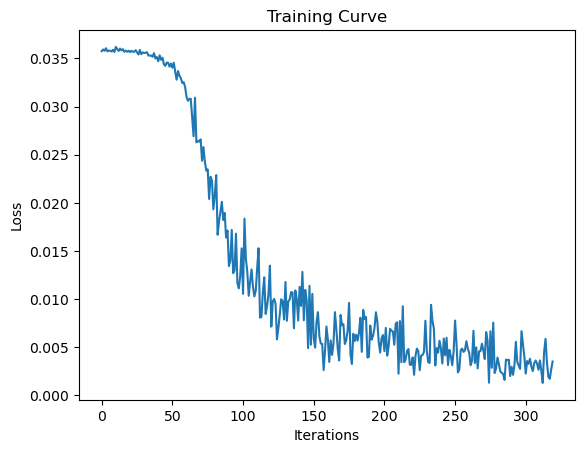

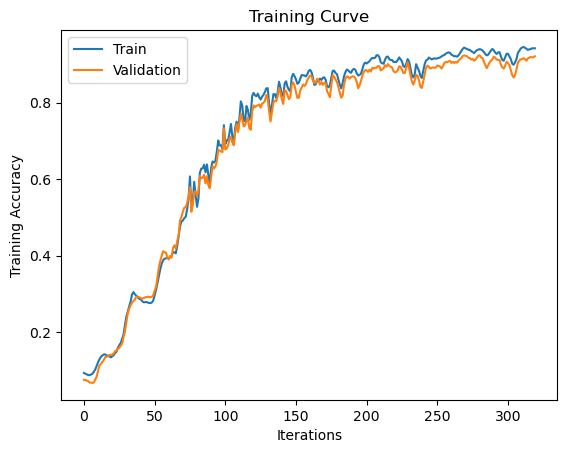

Final Training Accuracy: 0.942626953125
Final Validation Accuracy: 0.921875


In [5]:
#proper model
print("ANN")
model_ANN = ANN_MNISTClassifier()
print(model_ANN)
train(model_ANN, mnist_train, num_epochs=5)


print("CNN")
model = CNN_MNISTClassifier()
print(model)
train(model, mnist_train, num_epochs=5)


With 5 epochs selected it can take several minutes to train the network. With the power of GPUs we can greatly reduce the time required and put that to tune our hyperparameters to acheive better results.

## Enable GPU
PyTorch allows you to run the computations on a GPU to speed up the processing. In order to enable GPUs you will need to:
1. select GPUs in "Runtime" menu, "change runtime type".
2. setup **model** to work with the cuda
3. make sure **image** and **labels** data are stored placed on the GPU

An example of this is provided below.

In [6]:
def get_accuracy(model, train=False):
    if train:
        data = mnist_train
    else:
        data = mnist_val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total


In [7]:
def train(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    

In [8]:
!nvidia-smi

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Wed Oct  9 23:17:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.51.01              Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 33%   29C    P8             14W /  261W |     610MiB /   8192MiB |     15%      Default |
|                                         |                       

CUDA is available!  Training on GPU ...


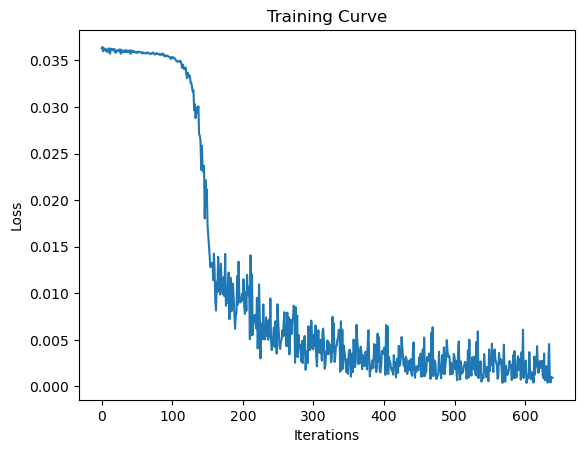

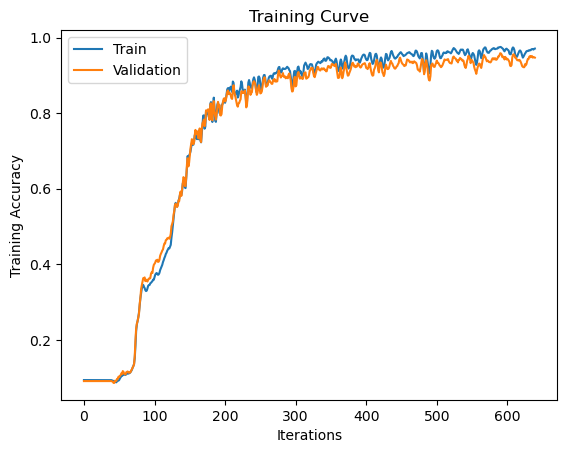

Final Training Accuracy: 0.97119140625
Final Validation Accuracy: 0.947265625


In [9]:
use_cuda = True

model = CNN_MNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(model, mnist_train, num_epochs=10)

## Practice to make sure you get the dimensions right

The general formula is this if you are interested: $[(W−K+2P)/S]+1$.

* $W$ is the input volume 
* $K$ is the Kernel size 
* $P$ is the padding 
* $S$ is the stride

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

x = torch.randn(20, 3, 28, 28) # N(batch size), C(channel), H(height), W(width)
conv = nn.Conv2d(in_channels=3, out_channels=7, kernel_size=5, padding=0)
print(conv(x).shape)


torch.Size([20, 7, 24, 24])


In [11]:
pool = nn.MaxPool2d(kernel_size=2, stride=2)
print(pool(x).shape)

torch.Size([20, 3, 14, 14])


## Visualize Kernels

Recall what our convolution layer looks like:

*self.conv1 = nn.Conv2d(1, 5, 5) #in_channels, out_chanels, kernel_size*

There are 5 out channels => 5 kernels, kernel size = 5 and in_channels = 1, hence we're using 5 x 5 kernels. 

In [12]:
import matplotlib.pyplot as plt

# Visualize conv1 kernels (i.e filter)
kernels = model.conv1.weight.detach()

print(kernels.shape)


torch.Size([5, 1, 5, 5])


We can also plot the kernels:

tensor([[ 0.1071, -0.1454, -0.2175, -0.2740, -0.2977],
        [ 0.0464, -0.1422, -0.0647, -0.0580, -0.2646],
        [ 0.3914,  0.3081, -0.0886, -0.1584,  0.0026],
        [ 0.4874,  0.4393,  0.5650,  0.4197,  0.1418],
        [ 0.3827,  0.7402,  0.7927,  0.6291,  0.4817]])


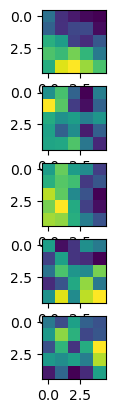

In [14]:
#this line is required if using GPU
kernels = kernels.cpu()

#display first kernel
print(kernels[0][0])

#display all five kernels of dimension 5 x 5
fig, axarr = plt.subplots(kernels.size(0))
for idx in range(kernels.size(0)):
    axarr[idx].imshow(kernels[idx][0])

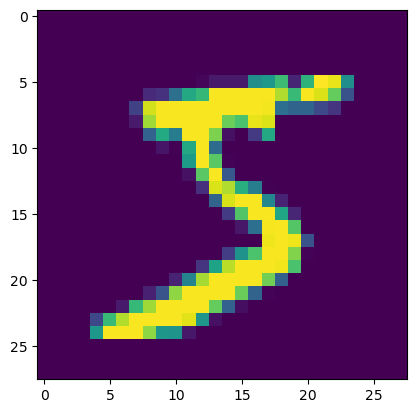

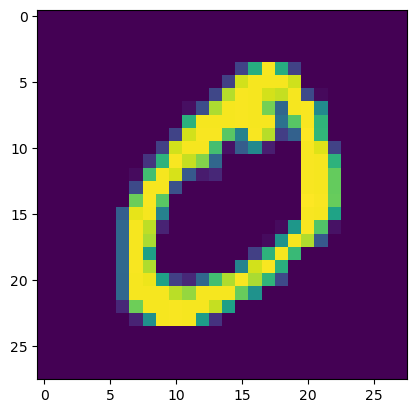

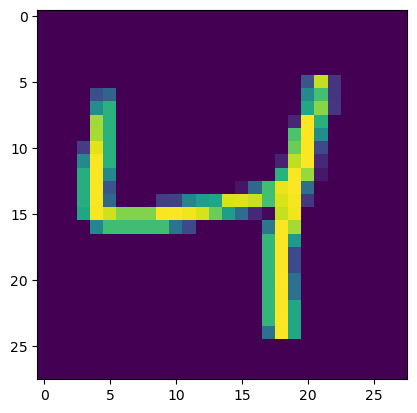

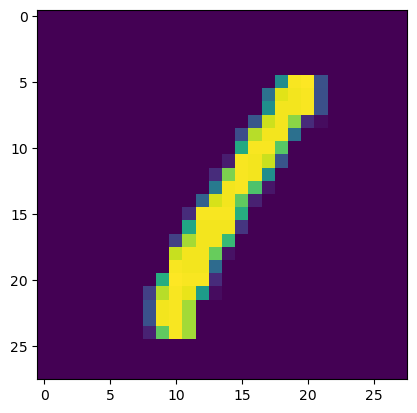

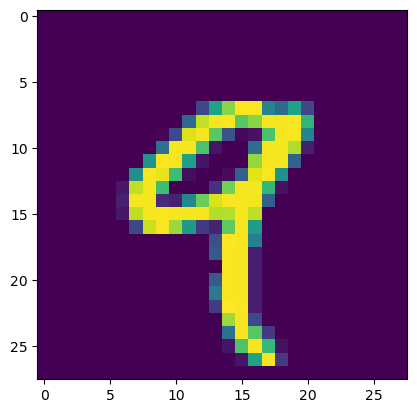

In [16]:
# show the first 5 examples from the dataset
for i in range(5):
    plt.imshow(mnist_train[i][0].squeeze(0))
    plt.show()

### Visualize Feature Map
We can also apply our kernel to our images to see what kind of features it extracts. In the example we will use a new image, but we could also apply this to one of the images in our training or validation data sets.

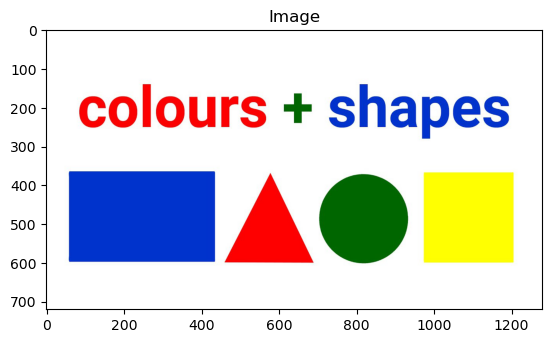

Image Max Value: 255 Image Min Value: 0


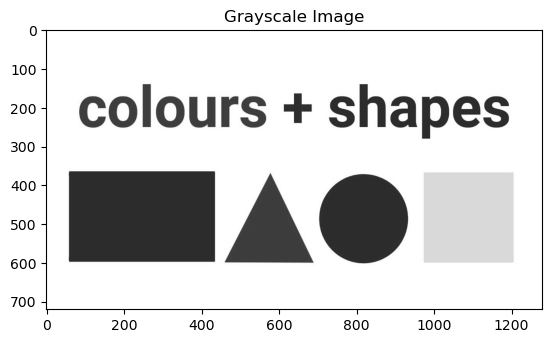



########### Conv Outputs ###########
Kernel:  0
Image Max Value: 1453.7112679255497 Image Min Value: -373.2125238729287
Image Max Value Normalized: 255.0 Image Min Value: 0.0


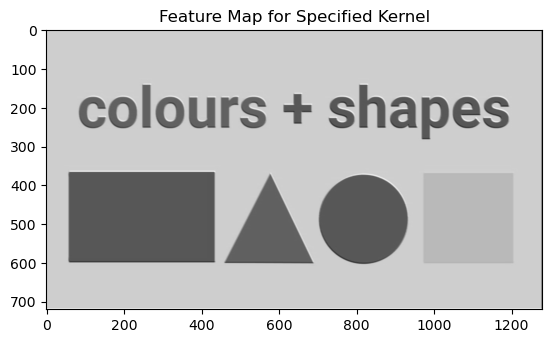

Kernel:  1
Image Max Value: 207.93251639043086 Image Min Value: -248.37093483034732
Image Max Value Normalized: 255.0 Image Min Value: 0.0


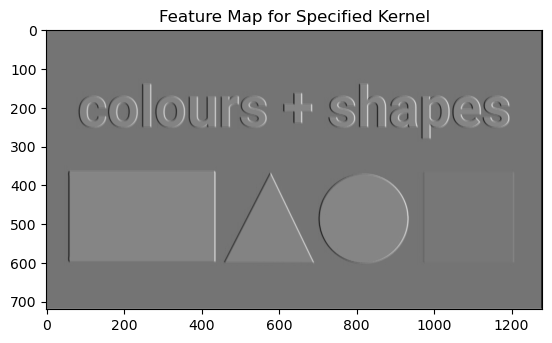

Kernel:  2
Image Max Value: 1347.4708562936455 Image Min Value: -256.2789391151651
Image Max Value Normalized: 255.0 Image Min Value: 0.0


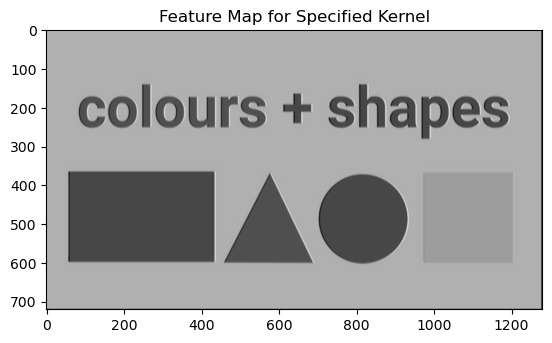

Kernel:  3
Image Max Value: 335.70188181652685 Image Min Value: -219.83325909619137
Image Max Value Normalized: 255.0 Image Min Value: 0.0


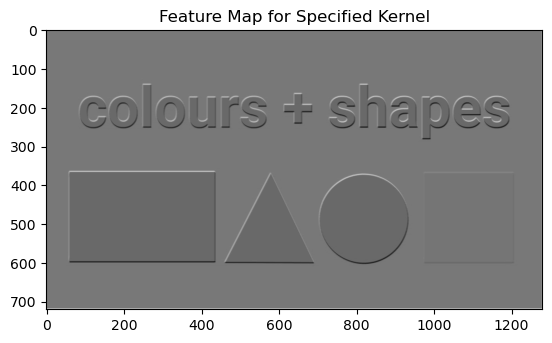

Kernel:  4
Image Max Value: 85.06829892529268 Image Min Value: -192.24809601791688
Image Max Value Normalized: 255.0 Image Min Value: 0.0


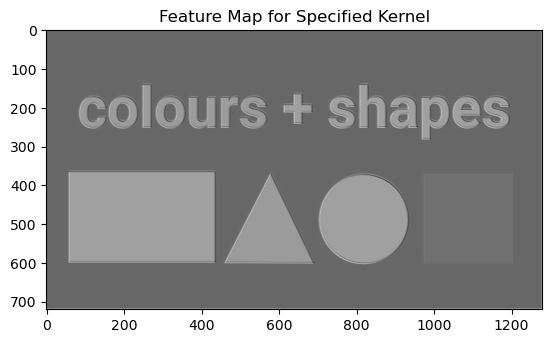

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg

from PIL import Image
import requests

#load image from the internet
url = 'https://i.ytimg.com/vi/BqKXHIRwGbs/maxresdefault.jpg'
resp = requests.get(url, stream=True).raw
img = Image.open(resp)

#ensure image is np.array
img = np.array(img)

#plot original image
plt.title("Image")
plt.imshow(img)
plt.show()

#increase data precision
img = img.astype(np.int16)
print('Image Max Value:', np.amax(img), 'Image Min Value:', np.amin(img))

#convert from colour to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
  
img_gray = rgb2gray(img)

#plot grayscale image
plt.title("Grayscale Image")
plt.imshow(img_gray, cmap='gray')
plt.show()

print ("\n\n########### Conv Outputs ###########")
#select kernel
for i in range (0,5):
  k = kernels[i][0]

  #perform 2d convolution
  img_k = sg.convolve(img_gray, k, mode='same')
  print ("Kernel: ", i)
  print('Image Max Value:', np.amax(img_k), 'Image Min Value:', np.amin(img_k))

  #clipping 
  #img_k[img_k > 255] = 255
  #img_k[img_k < 0] = 0

  #Normalizing
  img_k = (img_k-img_k.min())/(img_k.max()-img_k.min())*255

  print('Image Max Value Normalized:', np.amax(img_k), 'Image Min Value:', np.amin(img_k))

  #return to image format
  img_k = img_k.astype(np.uint8)

  #plot results of convolution
  plt.title("Feature Map for Specified Kernel")
  plt.imshow(img_k, cmap='gray')
  plt.show()